# Enrichment and Overlap of PGC2+CLOZUK

In [1]:
import re
import os, errno
import functools
import subprocess
import numpy as np
import pandas as pd
from plotnine import *
from pandas_plink import read_plink
from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation
from scipy.stats import fisher_exact, binom_test

filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

## Config and Functions

In [2]:
config = {
    'biomart_file': '../../../eQTL_analysis/caudate_eqtl/residualized_expression/plot_eqtls/_h/biomart.csv',
    'phenotype_file': '../../../../inputs/antipsychotics_phenotypes/_m/merged_phenotypes.csv',
    'plink_file_prefix': '../../../../inputs/genotypes/to_brnum/phase3_plink/_m/phase3',
    'gwas_snp_file': '../../../../inputs/gwas/PGC2_CLOZUK/map_phase3/_m/libd_hg38_pggc2sz_snps.tsv'
}

In [3]:
@functools.lru_cache()
def get_de_df():
    de_df = pd.read_csv(config_feature['de_file'], sep='\t', index_col=0)
    return de_df


@functools.lru_cache()
def get_eqtl_df(fdr=0.05):
    with subprocess.Popen('''awk ' ($6<%f) || (NR==1) {print}' %s ''' % 
                          (fdr, config_feature['matrixeqtl_output_file']),
                          shell=True, stdout=subprocess.PIPE) as p:
        eqtl_df = pd.read_csv(p.stdout, sep='\t')
    return eqtl_df


@functools.lru_cache()
def get_gwas_snps():
    return pd.read_csv(config['gwas_snp_file'], sep='\t', index_col=0, low_memory=False)


@functools.lru_cache()
def get_integration_df(fdr=0.05):
    dft = get_gwas_snps().merge(get_eqtl_df(fdr), left_on='our_snp_id', right_on='SNP', 
                                suffixes=['_PGC2', '_eqtl'])\
                         .merge(get_de_df(), left_on='gene', right_index=True)
    return dft


@functools.lru_cache()
def get_residual_expression_df():
    residual_expression_df = pd.read_csv(config_feature['residual_expression_file'], 
                                         sep='\t', index_col=0).transpose()
    return residual_expression_df


@functools.lru_cache()
def get_pheno_df():
    pheno_df = pd.read_csv(config['phenotype_file'], index_col=0)
    pheno_df['New_Dx'] = pheno_df.New_Dx.astype('category')\
                                 .cat.reorder_categories(['Control', 'Schizo_noAP', 'Schizo_AP'])
    return pheno_df

In [4]:
def agree_direction(row):
    return [-1, 1][row['pgc2_a1_same_as_our_counted']] * np.sign(row['OR'] - 1) * np.sign(row['t-stat']) * np.sign(row['t'])


def save_plot(p, fn):
    for ext in ['png', 'pdf', 'svg']:
        p.save(fn + '.' + ext)
        

In [5]:
def letter_snp(number, a0, a1):
    '''
    Example:
    letter_snp(0, 'A', 'G') is 'AA'
    letter_snp(1, 'A', 'G') is 'AG'
    letter_snp(2, 'A', 'G') is 'GG'
    
    '''
    if np.isnan(number):
        return np.nan
    if len(a0)==1 and len(a1)==1:
        sep = ''
    else:
        sep = ' '
    return sep.join(sorted([a0]*int(number) + [a1]*(2-int(number))))


def get_gwas_snp(snp_id):
    gwas = get_gwas_snps()
    r = gwas[gwas['our_snp_id']==snp_id]
    assert len(r) == 1
    return r

In [6]:
@functools.lru_cache()
def get_expression_and_pheno_df():
    return pd.merge(get_pheno_df(), get_residual_expression_df(), left_index=True, right_index=True)


@functools.lru_cache()
def get_plink_tuple():
    '''
    Usage: (bim, fam, bed) = get_plink_tuple()
    '''
    return read_plink(config['plink_file_prefix'])


@functools.lru_cache()
def get_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the same as in the plink files.
    
    Example: 
    get_snp_df('rs653953').head(5)
    
            rs653953_num rs653953_letter rs653953
    Br5168             0              GG    0\nGG
    Br2582             1              AG    1\nAG
    Br2378             1              AG    1\nAG
    Br5155             2              AA    2\nAA
    Br5182             2              AA    2\nAA
    '''
    (bim, fam, bed) = get_plink_tuple()
    brain_ids = list(set(get_expression_and_pheno_df()['BrNum']).intersection(set(fam['fid'])))
    
    snp_info = bim[bim['snp']==snp_id]
    snp_pos = snp_info.iloc[0]['i']
    fam_pos = list(fam.set_index('fid').loc[brain_ids]['i'])
    
    dfsnp = (pd.DataFrame(bed[[snp_pos]].compute()[:,fam_pos], columns=brain_ids, index=[snp_id + '_num'])
             .transpose().dropna())
    
    my_letter_snp = functools.partial(letter_snp, a0=snp_info.iloc[0]['a0'], a1=snp_info.iloc[0]['a1'])
    
    # the 2 - in next line is to workaround a possible bug in pandas_plink? a1 and a0 inverted
    dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']].astype('int')
    dfsnp[snp_id + '_letter'] = dfsnp[snp_id + '_num'].apply(my_letter_snp)
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    return dfsnp


@functools.lru_cache()
def get_gwas_ordered_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the number of risk alleles according to GWAS.
    
    Example: 
    get_gwas_ordered_snp_df('rs653953').head(5)
    
            rs653953_num rs653953_letter rs653953
    Br5168             2              GG    2\nGG
    Br2582             1              AG    1\nAG
    Br2378             1              AG    1\nAG
    Br5155             0              AA    0\nAA
    Br5182             0              AA    0\nAA
    '''
    pgc = get_gwas_snps()
    dfsnp = get_snp_df(snp_id).copy()
    gwas_snp = get_gwas_snp(snp_id)
    
    if gwas_snp['pgc2_a1_same_as_our_counted'].iloc[0]:
        if gwas_snp['OR'].iloc[0] > 1:
            pass
        else:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
    else:
        if gwas_snp['OR'].iloc[0] > 1:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
        else:
            pass
        
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    return dfsnp

In [7]:
@functools.lru_cache()
def get_biomart_df():
    biomart = pd.read_csv(config['biomart_file'])
    biomart['description'] = biomart['description'].str.replace('\[Source.*$','')
    return biomart

In [8]:
def get_gene_symbol(gene_id, biomart=get_biomart_df()):
    ensge = re.sub('\..+$','', gene_id)
    ggg = biomart[biomart['ensembl_gene_id']==ensge]
    if ggg.shape[0]==0:
        return '', ''

    gs = ggg['external_gene_name'].values[0]
    de = ggg['description'].values[0]
    if type(de)!=str:
        de = ''
        
    de = re.sub('\[Source:.*$','',de)
    return gs, de

In [9]:
@functools.lru_cache()
def get_risk_allele(snp_id):
    gwas_snp = get_gwas_snp(snp_id)
    
    if gwas_snp['OR'].iloc[0] > 1:
        ra = gwas_snp['A1'].iloc[0]
    else:
        ra = gwas_snp['A2'].iloc[0]
    
    return ra

In [10]:
def get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func):
    pheno_columns = list(get_pheno_df().columns)
    expr_df = get_expression_and_pheno_df()[pheno_columns + [gene_id]]
    snp_df =  snp_df_func(snp_id)
    return expr_df.merge(snp_df, left_on='BrNum', right_index=True)


def simple_snp_expression_pheno_plot_impl(snp_id, gene_id, snp_df_func, pheno_var):
    df = get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func)
    df['Dx'] = df.Dx.astype('category').cat.rename_categories({'Control': 'CTL', 'Schizo': 'SZ'})
    y0 = df[gene_id].quantile(.01) - 0.26
    y1 = df[gene_id].quantile(.99) + 0.26
    pjd = position_jitterdodge(jitter_width=0.27)
    p = ggplot(df, aes(x=snp_id, y=gene_id, fill=pheno_var)) \
    + geom_boxplot(alpha=0.4, outlier_alpha=0) \
    + geom_jitter(position=pjd, stroke=0, alpha=0.6) + ylim(y0, y1) \
    + labs(y='Residualized expression', fill='Diagnosis') \
    + theme_matplotlib()\
    + theme(axis_text=element_text(size=18), 
            axis_title=element_text(size=21), 
            plot_title=element_text(size=22), 
            legend_text=element_text(size=14), 
            legend_title=element_text(size=16, face='bold'))
    return p


def simple_gwas_ordered_snp_expression_pheno_plot(snp_id, gene_id, pheno_var):
    return simple_snp_expression_pheno_plot_impl(snp_id, gene_id, get_gwas_ordered_snp_df, pheno_var)

In [29]:
def gwas_annotation(snp_id):
    return 'SZ GWAS pvalue: %.1e' % get_gwas_snp(snp_id).iloc[0]['P']


def eqtl_annotation(snp_id, gene_id):
    eqtl_df = get_eqtl_df()
    r = eqtl_df[(eqtl_df['SNP']==snp_id) & (eqtl_df['gene']==gene_id)]
    assert len(r)==1
    return 'eQTL FDR: %.1e' % r.iloc[0]['FDR']


def de_annotation(gene_id):
    de_df = get_de_df()
    de_df['Feature'] = de_df.index
    g = de_df[(de_df['Feature'] == gene_id)]
    return 'DE adj.P.Val: %.3f' % g.iloc[0]['adj.P.Val']


def risk_allele_annotation(snp_id):
    return 'SZ risk allele: %s' % get_risk_allele(snp_id)


def gwas_annotated_eqtl_pheno_plot(snp_id, gene_id, pheno_var):
    p = simple_gwas_ordered_snp_expression_pheno_plot(snp_id, gene_id, pheno_var)
    de_df = get_de_df()
    de_df['Feature'] = de_df.index
    de_df = de_df[(de_df['Feature'] == gene_id)]
    gene_symbol = de_df.iloc[0]['newGeneSymbol']
    
    title ="\n".join([gene_symbol,
                      gene_id,
                      gwas_annotation(snp_id),
                      risk_allele_annotation(snp_id),
                      eqtl_annotation(snp_id, gene_id), 
                      de_annotation(gene_id)])
    
    p += ggtitle(title) 
    return p

## Junctions

In [12]:
config_feature = {
    'de_file': '../../../differential_expression/_m/junctions/diffExpr_szVctl_full.txt',
    'residual_expression_file': '../../../differential_expression/_m/junctions/residualized_expression.tsv',
    'matrixeqtl_output_file': '../../../eQTL_analysis/caudate_eqtl/_m/cis_eqtl_junctions.ctxt',
}

In [13]:
feature = 'junctions'
try:
    os.makedirs(feature)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

### Enrichment

#### Integrate DEG with PGC2+CLOZUK SNPs

In [14]:
dft = get_integration_df()
dft.shape

/home/jbenja13/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


(4396997, 49)

In [15]:
agreement = {1: 'Yes', -1: 'No', 0: 0}
dft['agree_direction'] = dft.apply(agree_direction, axis=1)
dft.agree_direction = [agreement[item] for item in dft['agree_direction']]

In [16]:
table =  [[np.sum((dft['P']<5e-8) & ((dft['adj.P.Val']<.05))),
           np.sum((dft['P']<5e-8) & ((dft['adj.P.Val']>=.05)))],
          [np.sum((dft['P']>=5e-8) & ((dft['adj.P.Val']<.05))),
           np.sum((dft['P']>=5e-8) & ((dft['adj.P.Val']>=.05)))]]
print(table)
fisher_exact(table)

[[9343, 87686], [203173, 4096795]]


(2.1484949099631714, 0.0)

In [17]:
dft1 = dft[(dft['P']<5e-8) & ((dft['adj.P.Val']<.05))]
df = dft1.groupby('agree_direction').size().reset_index()
df

,agree_direction,0
0,No,313
1,Yes,9030


In [18]:
binom_test(df[0].iloc[1], df[0].sum())

0.0

In [19]:
dft2 = dft[(dft['P']<=5e-8)]
dft2 = dft2[(dft2['CtrlvsSZ'] != 0)]
dft2['risk_allele'] = dft2['our_snp_id'].apply(get_risk_allele)

In [21]:
direction = {-1: 'Down', 1: 'Up'}
boolean_conv = {True: 1, False: -1}
dft2.pgc2_a1_same_as_our_counted = [boolean_conv[item] for item in dft2['pgc2_a1_same_as_our_counted']]
dft2['eqtl_gwas_dir'] = [direction[item] for item in np.sign(dft2['pgc2_a1_same_as_our_counted']) * np.sign(dft2['t-stat']) * np.sign(dft2['OR'] - 1)]
dft2['de_dir'] = [direction[item] for item in np.sign(dft2['t'])]
dft2['eqtl_t'] = np.sign(dft2['pgc2_a1_same_as_our_counted']) * np.sign(dft2['OR'] - 1) * dft2['t-stat']

dft2 = dft2[['gene', 'Symbol', 'ensemblID', 'SNP_eqtl', 'A1', 'A2', 'risk_allele', 'OR', 
             'P', 'FDR', 'adj.P.Val', 'logFC', 't', 'eqtl_t', 
             'de_dir', 'eqtl_gwas_dir', 'agree_direction']]
dft2.to_csv('%s/integration_by_symbol.txt' % feature, sep='\t', index=False)
dft2['Symbol'].fillna(dft2['gene'], inplace=True)
df2 = dft2.groupby(['Symbol']).first().reset_index().sort_values('P')

In [22]:
df2.groupby('agree_direction').size()

agree_direction
No     13
Yes    21
dtype: int64

In [23]:
df2.set_index('Symbol').rename(columns={'t': 'de_t', 'P': 'GWAS_P', 'FDR': 'eQTL_FDR', 
                                        'adj.P.Val': 'de_adj.P.Val'})

,gene,ensemblID,SNP_eqtl,A1,A2,risk_allele,OR,GWAS_P,eQTL_FDR,de_adj.P.Val,logFC,de_t,eqtl_t,de_dir,eqtl_gwas_dir,agree_direction
Symbol,,,,,,,,,,,,,,,,
HLA-C,chr6:31270086-31270209(-),ENSG00000204525,rs3095336,G,A,G,1.218800,6.250000e-30,0.000005,0.005951,-1.743213,-3.963936,-5.737256,Down,Down,Yes
C4A,chr6:31984179-31984275(+),ENSG00000244731,rs3130923:31462135:G:A,G,A,G,1.183100,5.000000e-28,0.022737,0.048353,0.271797,3.070686,3.661151,Up,Up,Yes
C4B,chr6:32017147-32023929(+),ENSG00000224389,rs9281523:31498244:G:GC,G,GC,G,1.177150,1.610000e-26,0.026615,0.033004,0.306881,3.250623,3.608931,Up,Up,Yes
chr6:32554972-32584108(-),chr6:32554972-32584108(-),NaN,rs394439:32025555:C:A,C,A,C,1.135100,2.250000e-19,0.021854,0.039909,-0.808308,-3.162214,-3.674107,Down,Down,Yes
chr6:28271935-28272021(+),chr6:28271935-28272021(+),NaN,rs760587:27740300:C:A,C,A,C,1.104300,7.130000e-18,0.002625,0.019827,-0.257415,-3.470593,-4.296170,Down,Down,Yes
PPP1R10,chr6:30604736-30604993(-),ENSG00000204569,rs5875276:30824451:T:C,T,C,T,1.128600,2.320000e-17,0.030562,0.011216,-0.136188,-3.713808,3.562152,Down,Up,No
HLA-B,chr6:31355593-31356166(-),ENSG00000234745,rs5875276:30824451:T:C,T,C,T,1.128600,2.320000e-17,0.002645,0.021010,-1.604964,-3.446858,-4.294108,Down,Down,Yes
BAG6,chr6:31643978-31644081(-),ENSG00000204463,rs3993747:31580507:A:G,A,G,G,0.927510,6.440000e-13,0.000257,0.012724,-0.107853,-3.662057,4.874742,Down,Up,No
NGEF,chr2:232888108-232891357(-),ENSG00000066248,rs1878289:233791608:C:G,C,G,G,0.934740,1.270000e-12,0.014749,0.012971,0.117257,3.654353,-3.799455,Up,Down,No


### Plot with PGC2 risk allele

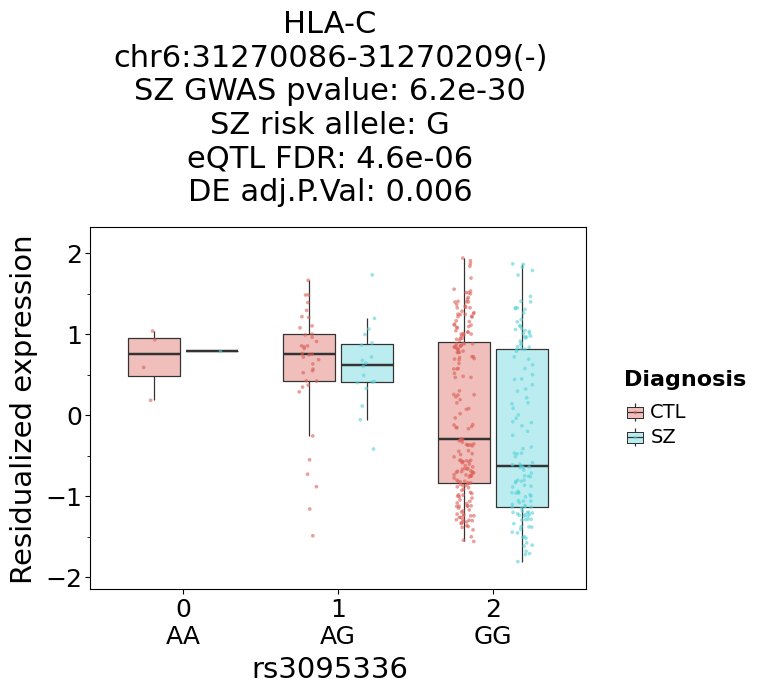

<ggplot: (8746771680756)>


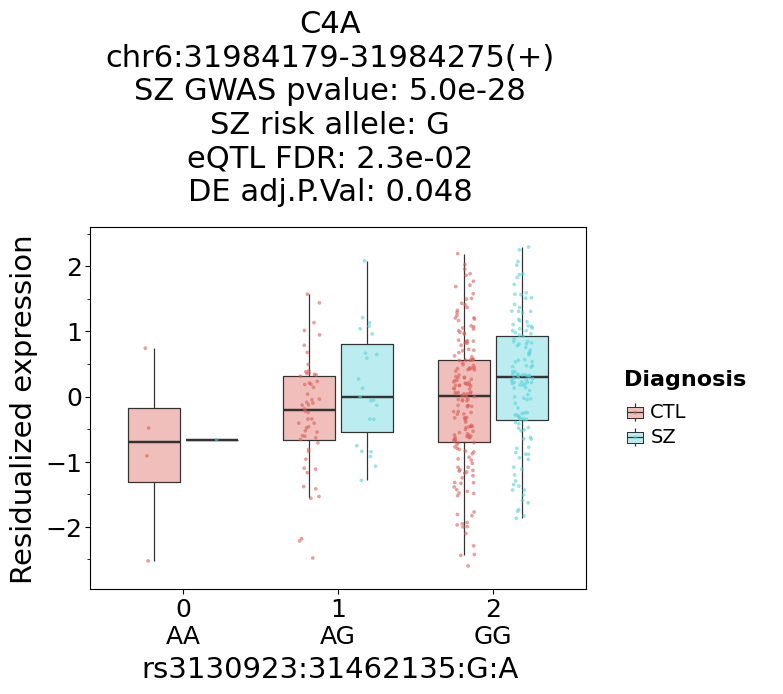

<ggplot: (8745935654518)>


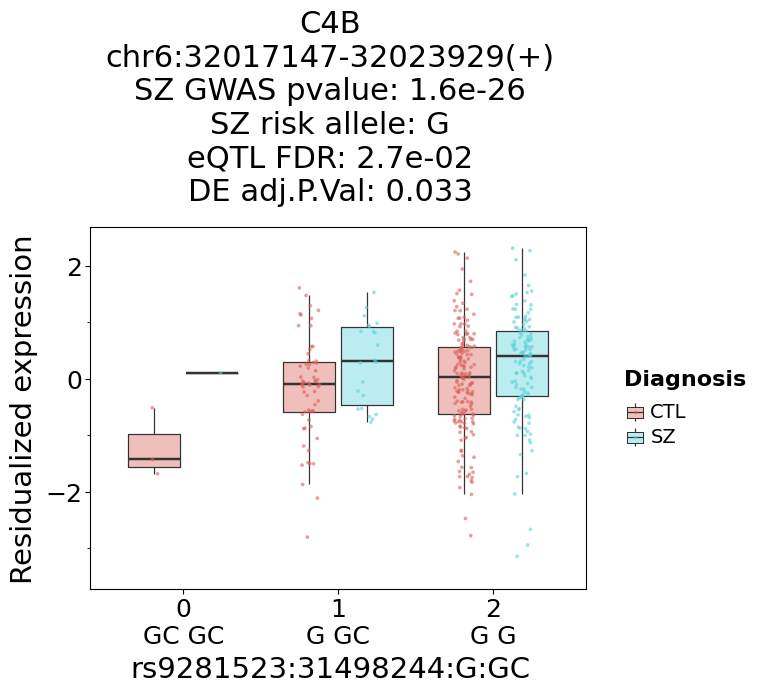

<ggplot: (8745935579724)>


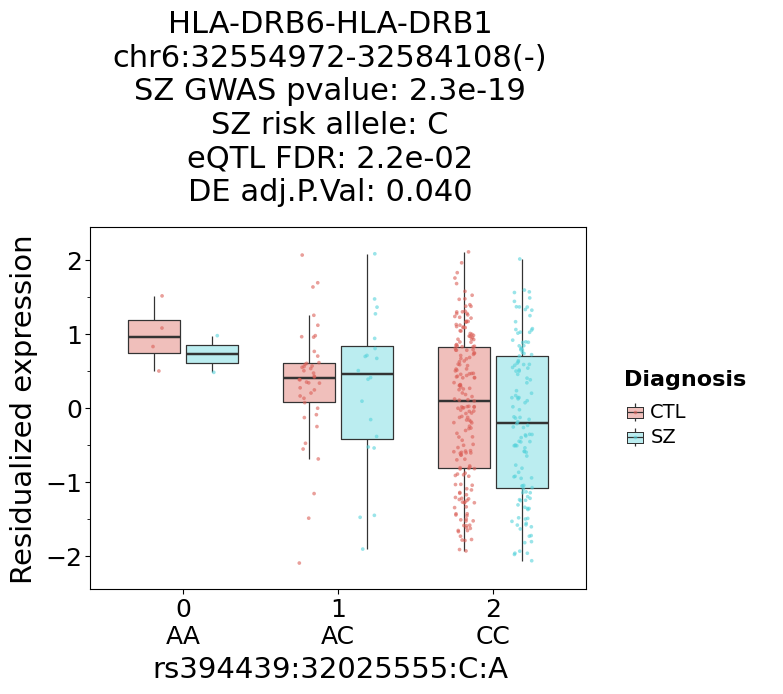

<ggplot: (8745935388398)>


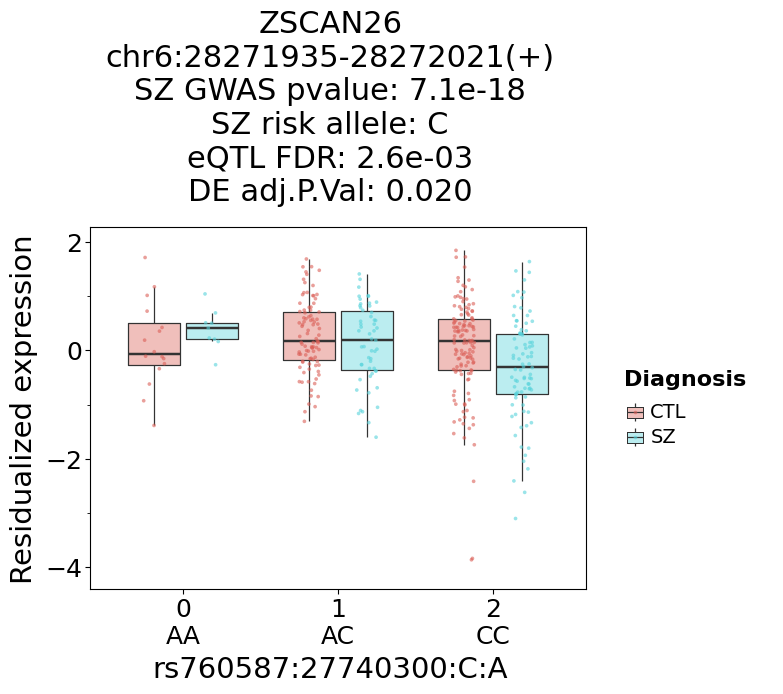

<ggplot: (8746637658263)>


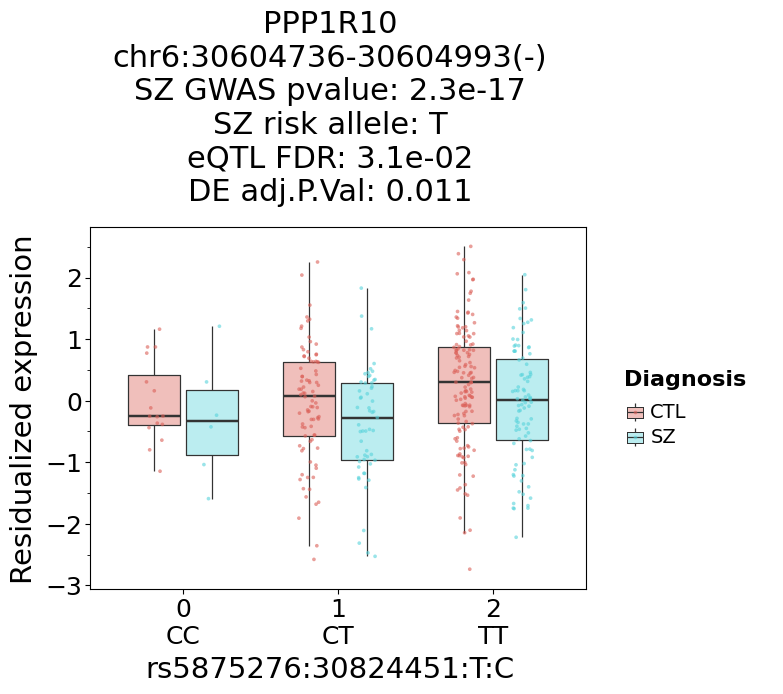

<ggplot: (8745936072039)>


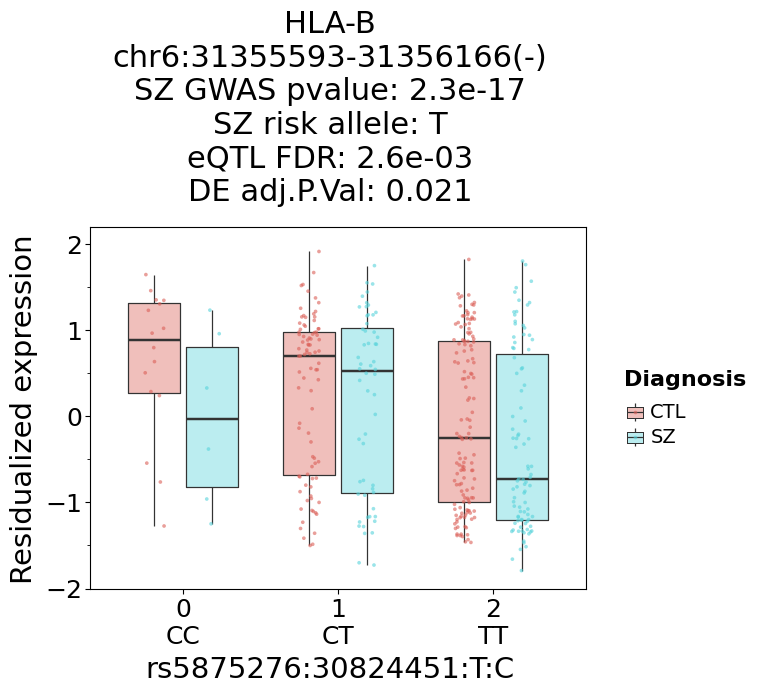

<ggplot: (8746637735807)>


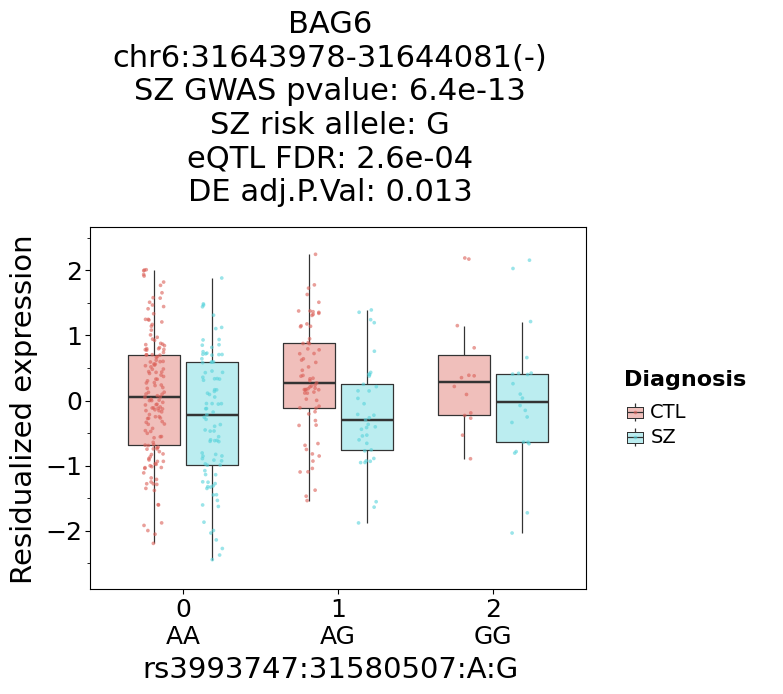

<ggplot: (8745935984975)>


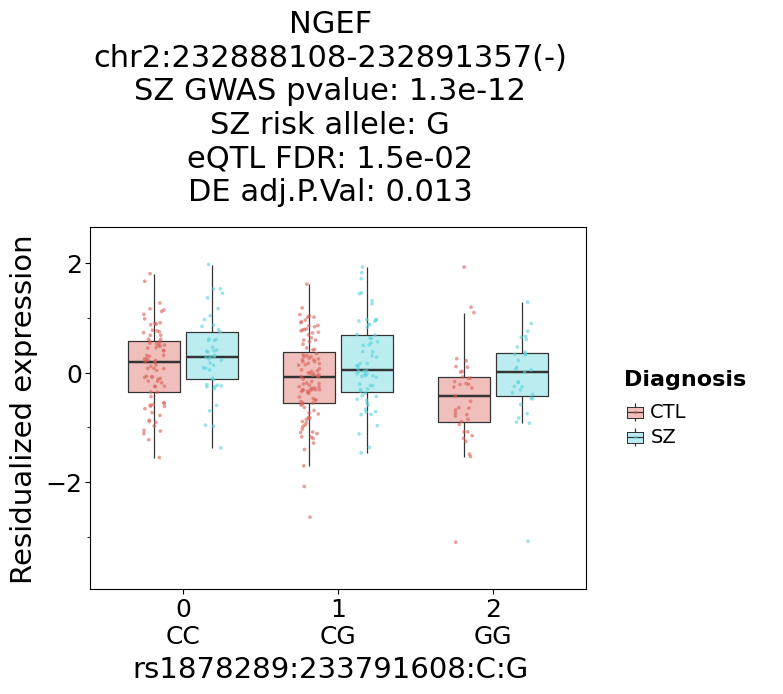

<ggplot: (8745973420632)>


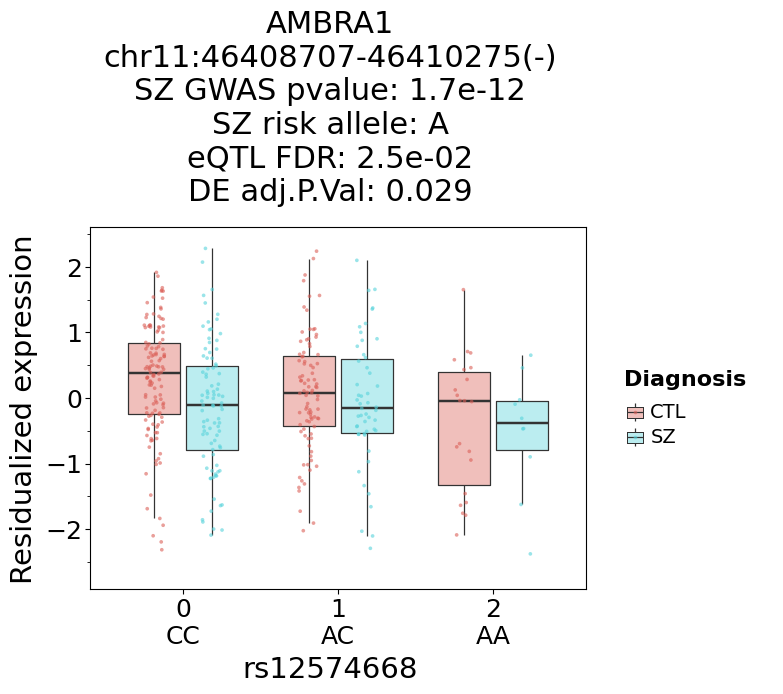

<ggplot: (8746637680475)>


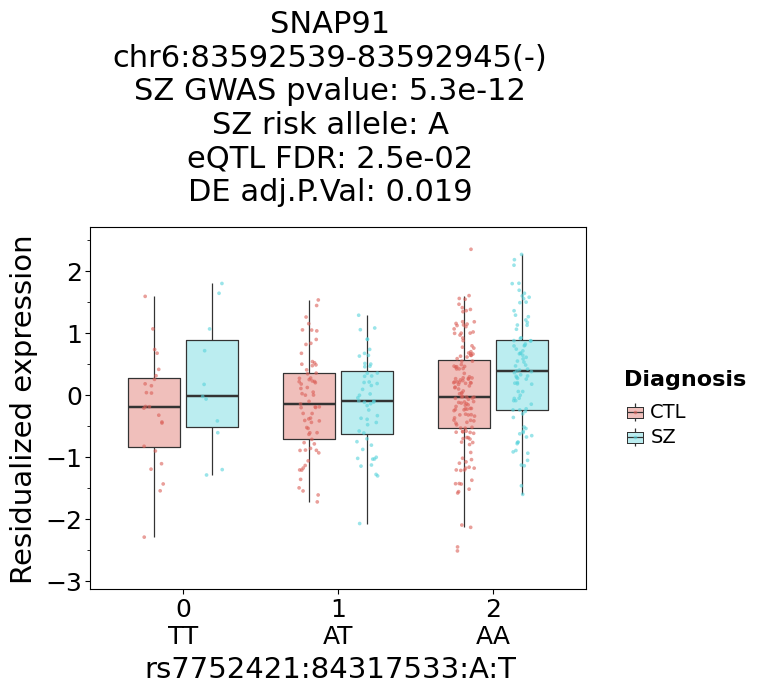

<ggplot: (8746637680448)>


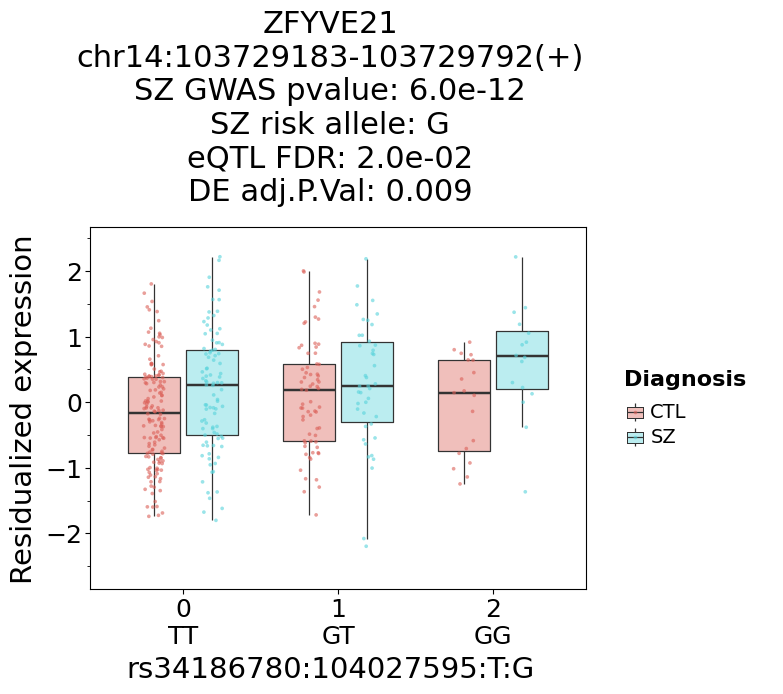

<ggplot: (8745973388255)>


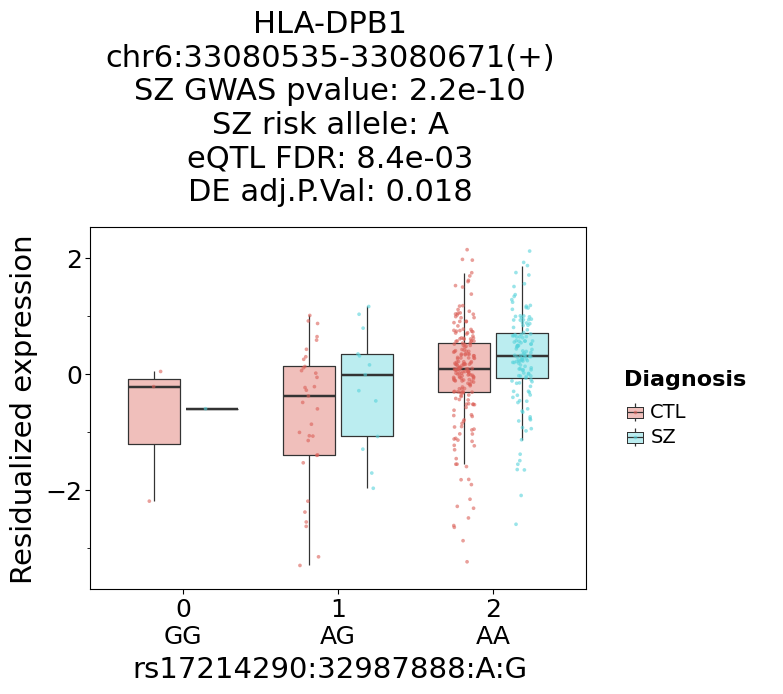

<ggplot: (8745973439184)>


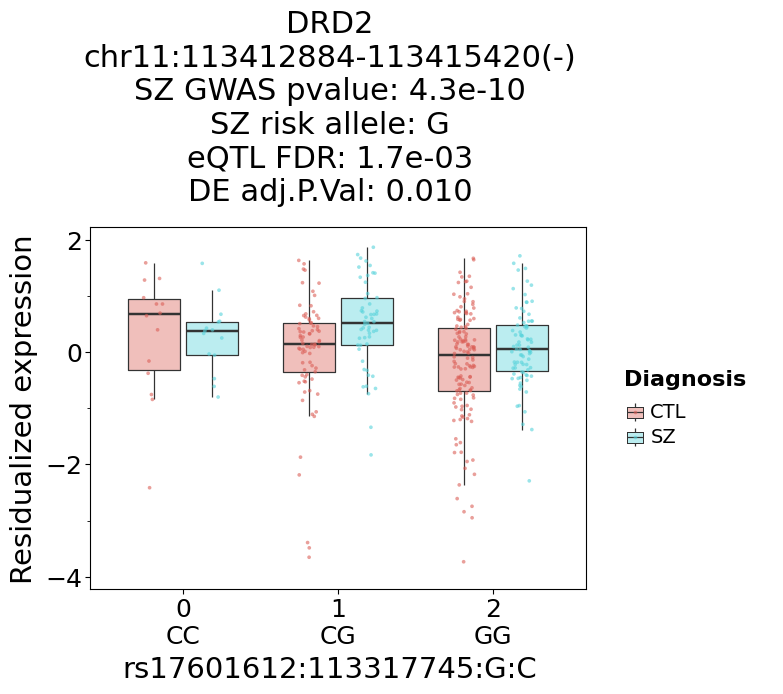

<ggplot: (8745973487583)>


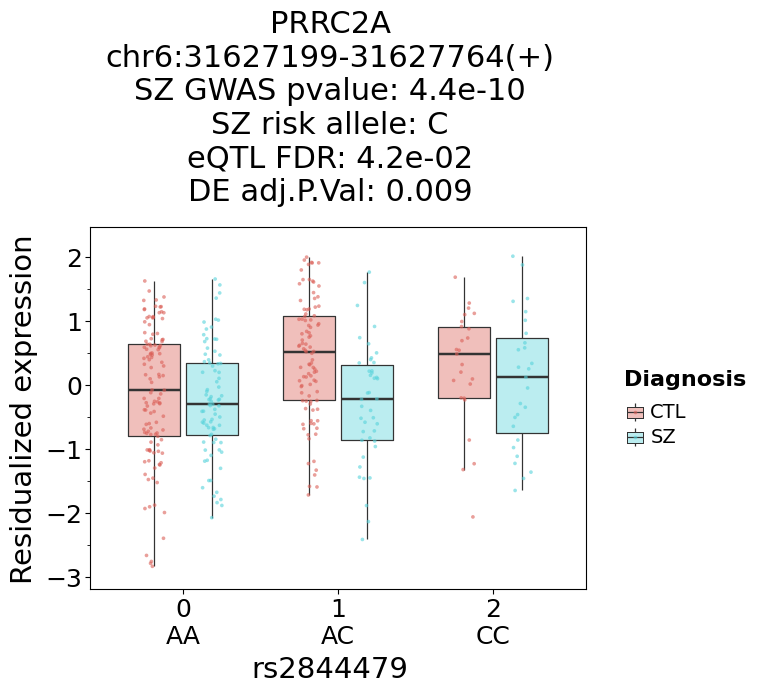

<ggplot: (8745935556602)>


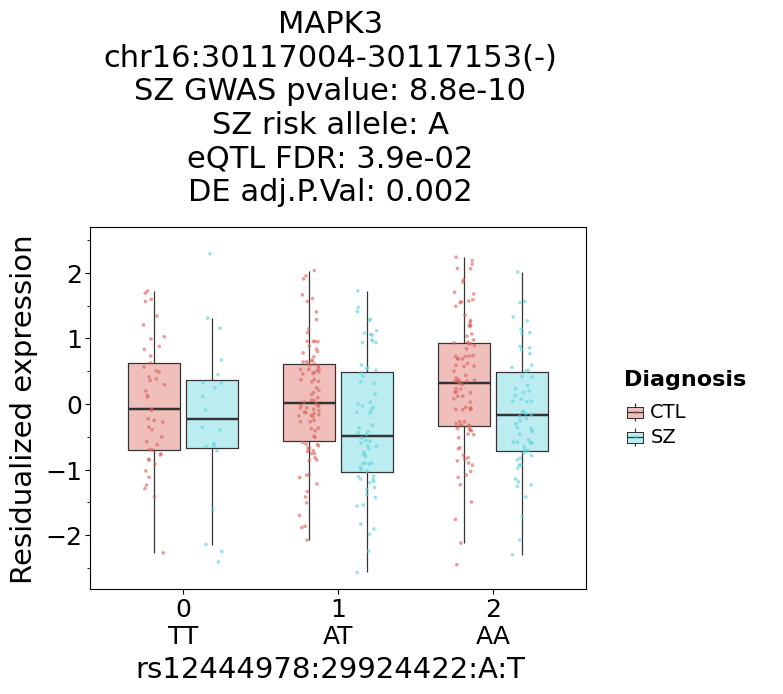

<ggplot: (8745935952165)>


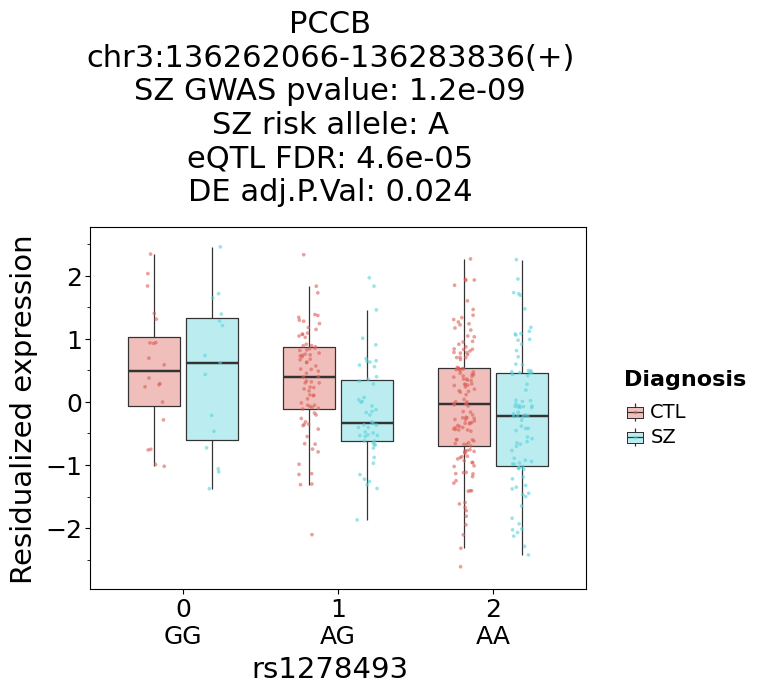

<ggplot: (8746637680490)>


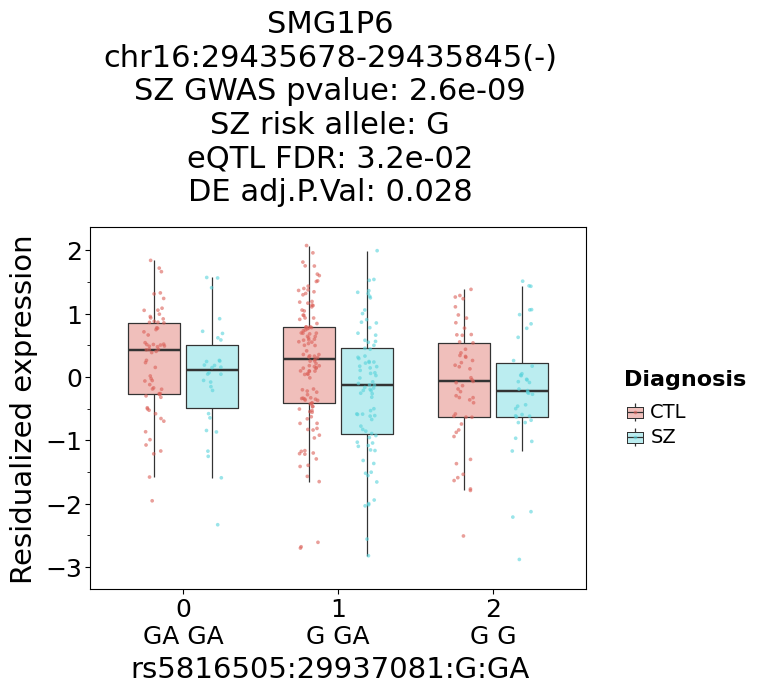

<ggplot: (8746638326956)>


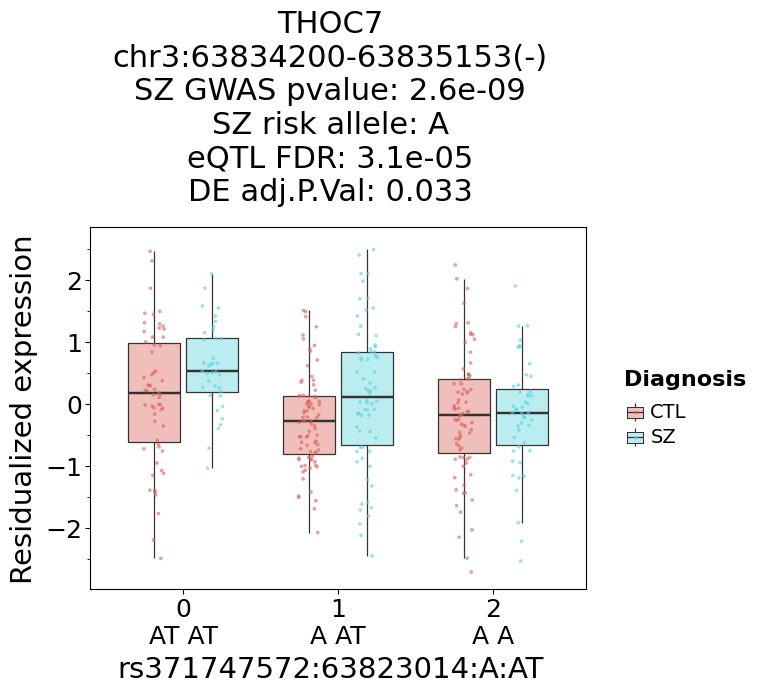

<ggplot: (8745935883918)>


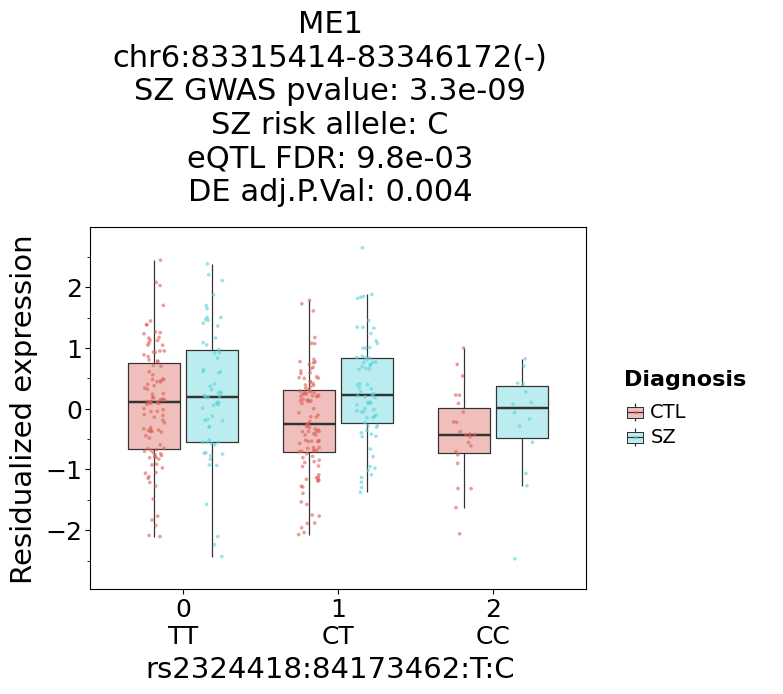

<ggplot: (8745973467504)>


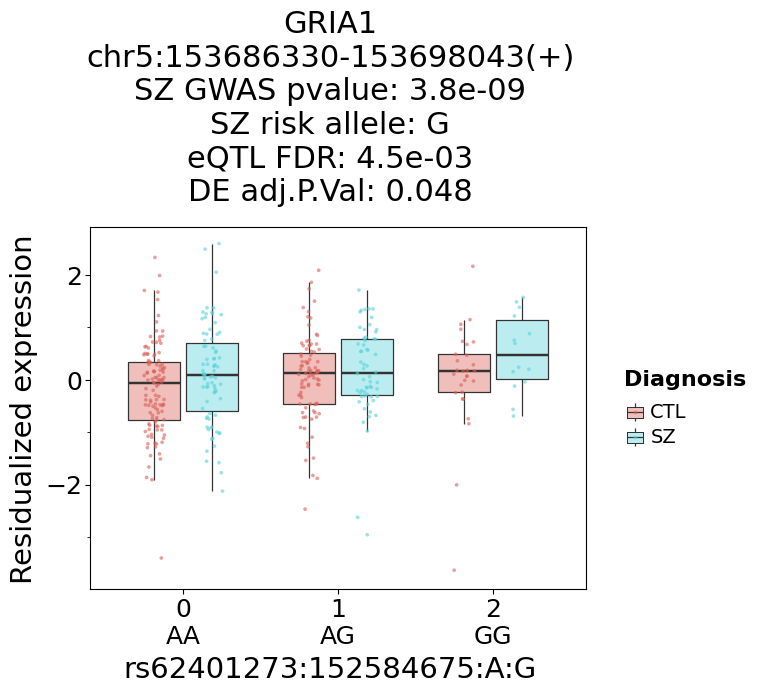

<ggplot: (8745973449897)>


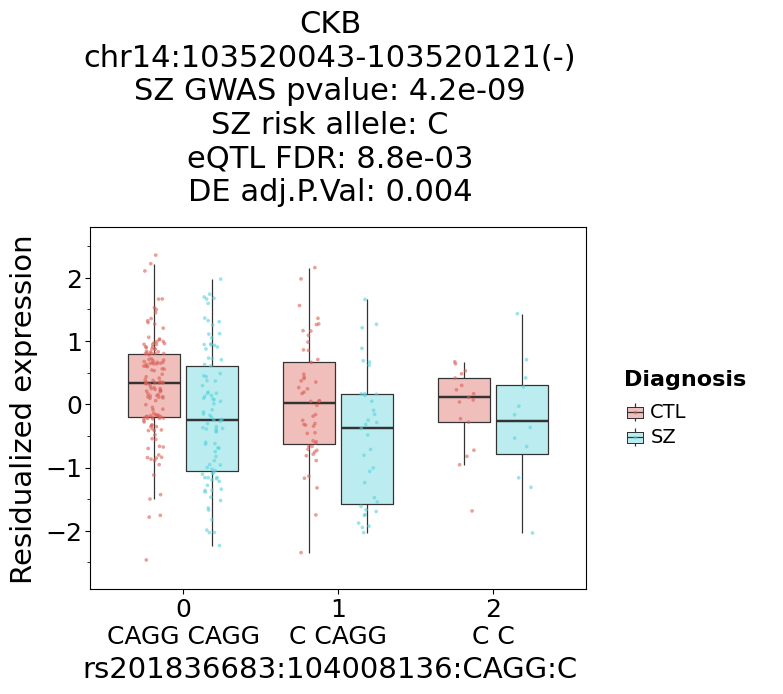

<ggplot: (8745936008394)>


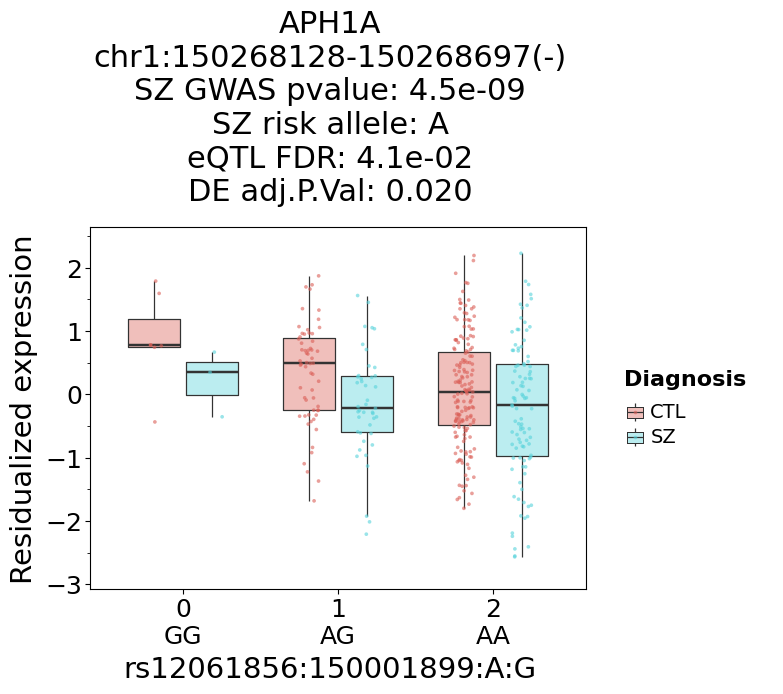

<ggplot: (8745935776793)>


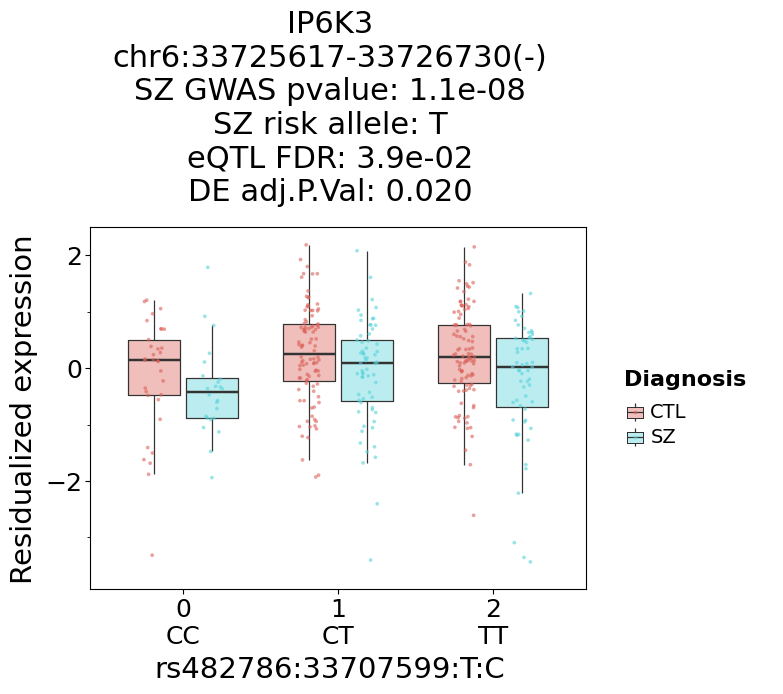

<ggplot: (8745935864257)>


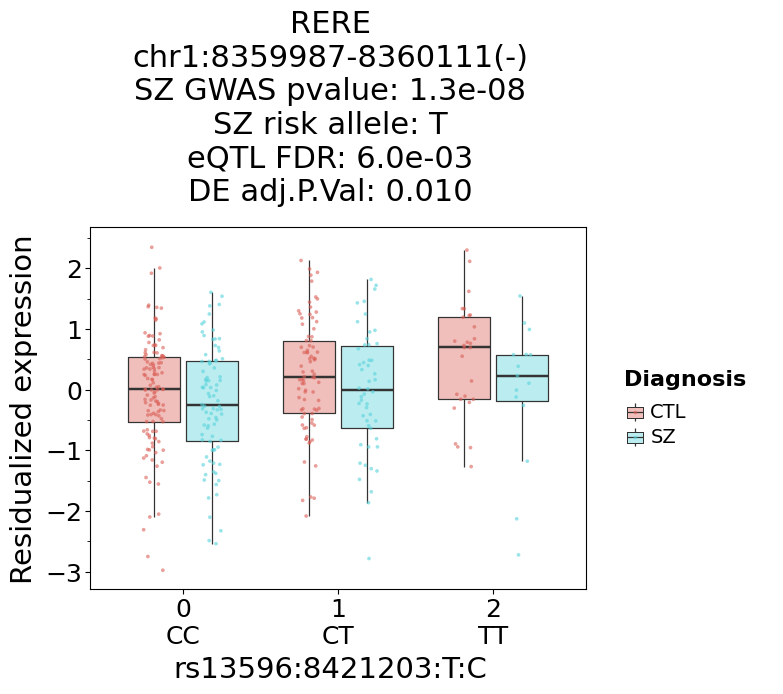

<ggplot: (8745935373279)>


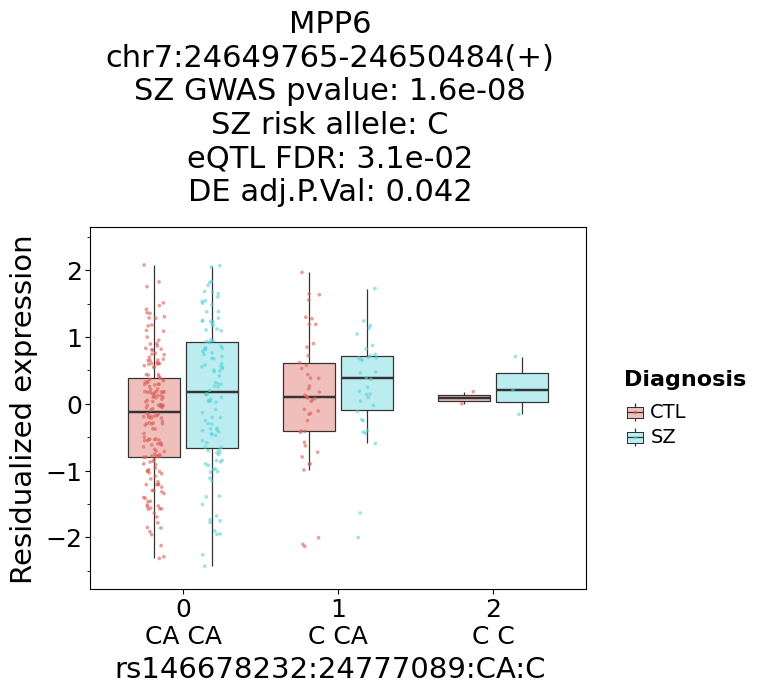

<ggplot: (8745935331717)>


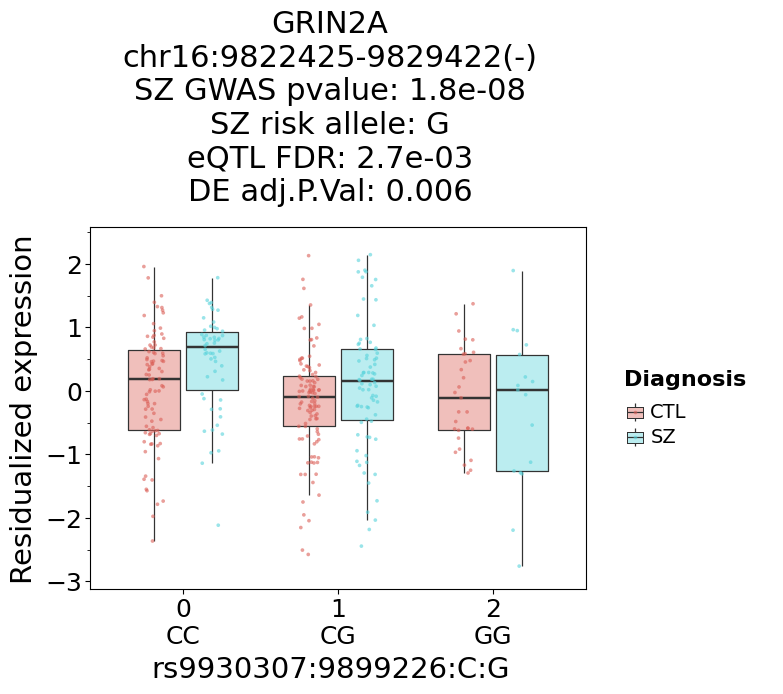

<ggplot: (8746637702506)>


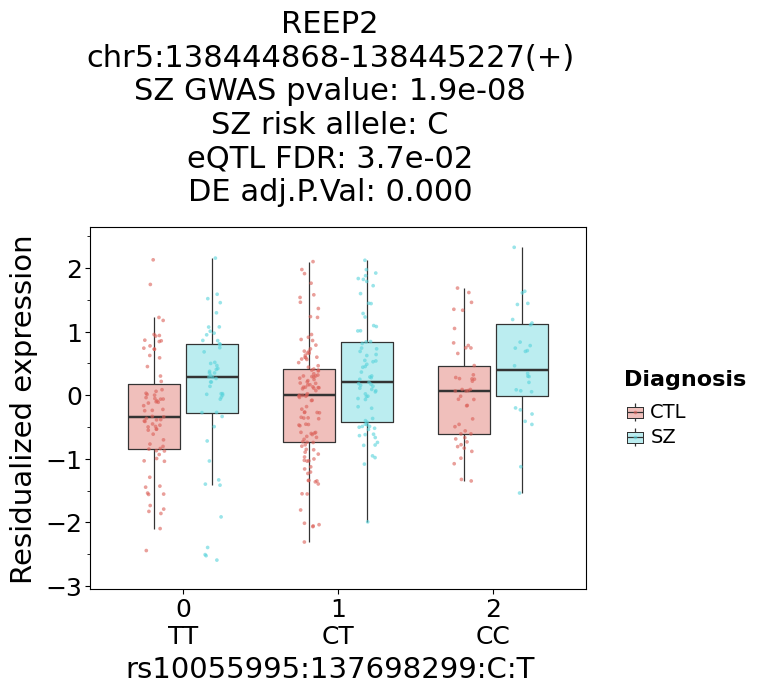

<ggplot: (8745935891173)>


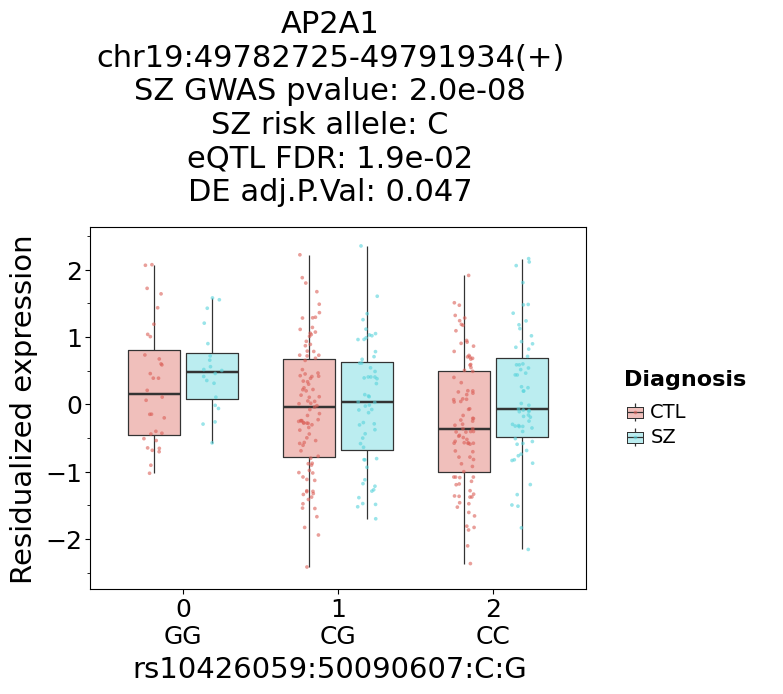

<ggplot: (8745936133753)>


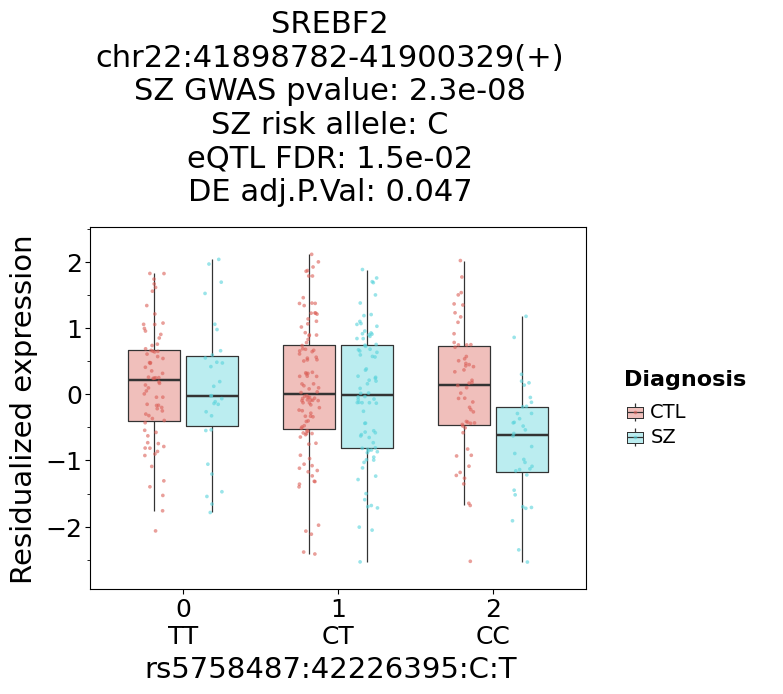

<ggplot: (8746637739963)>


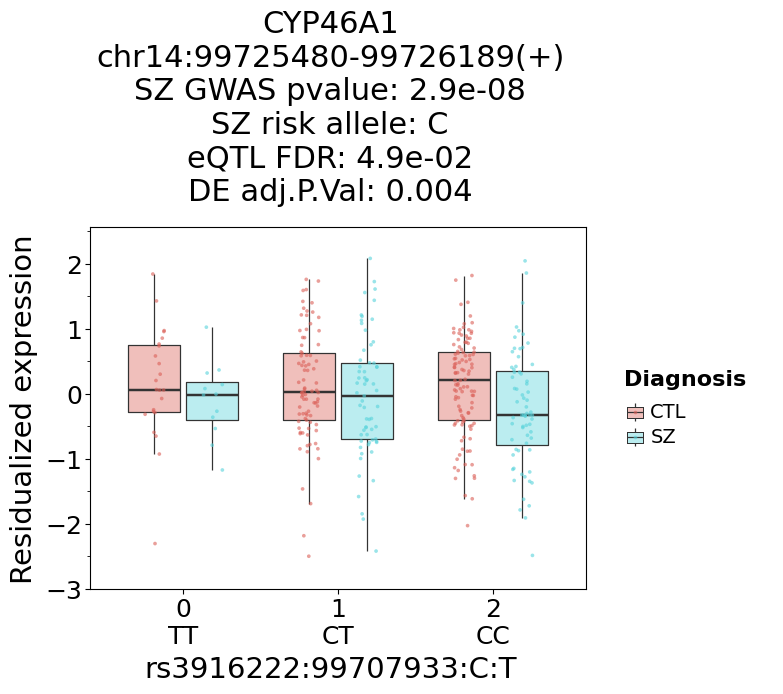

<ggplot: (8745935573598)>


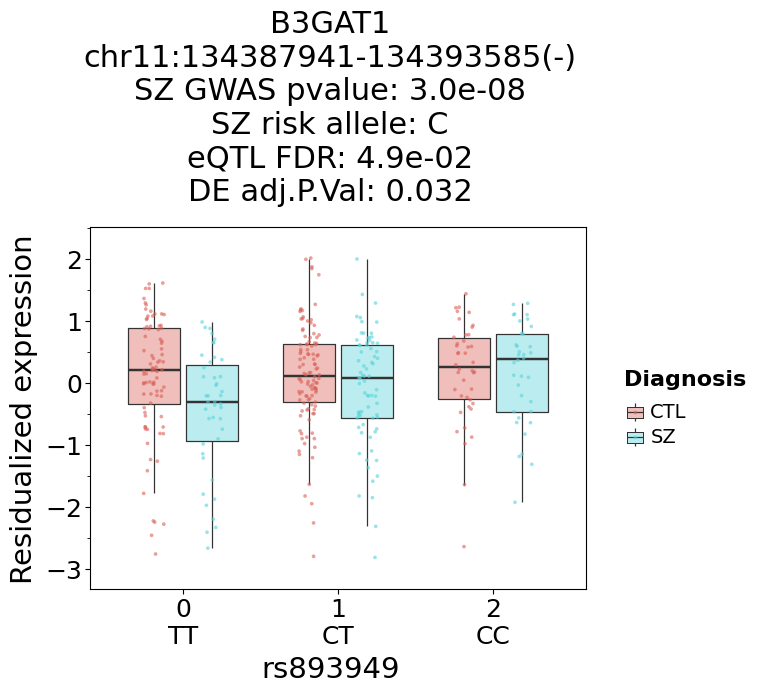

<ggplot: (8746638326995)>


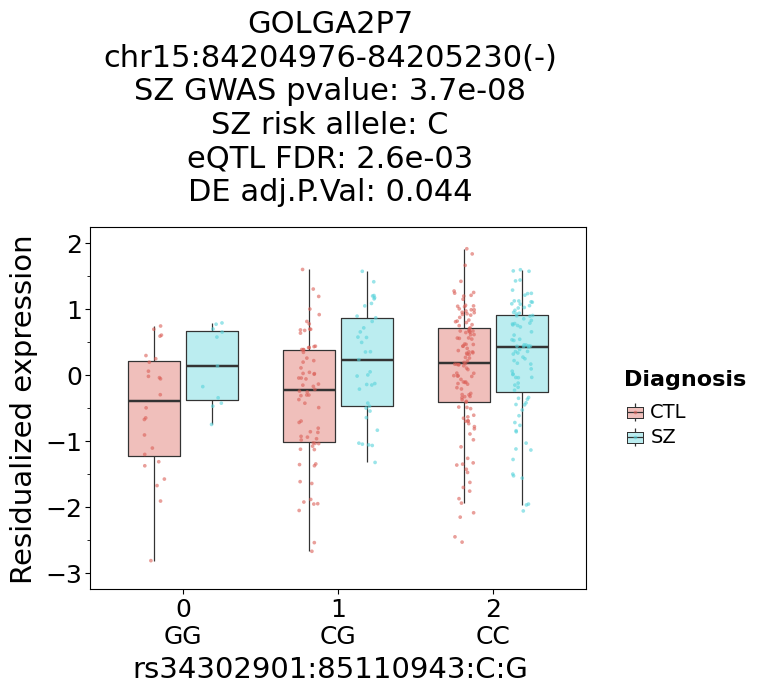

<ggplot: (8745973373091)>


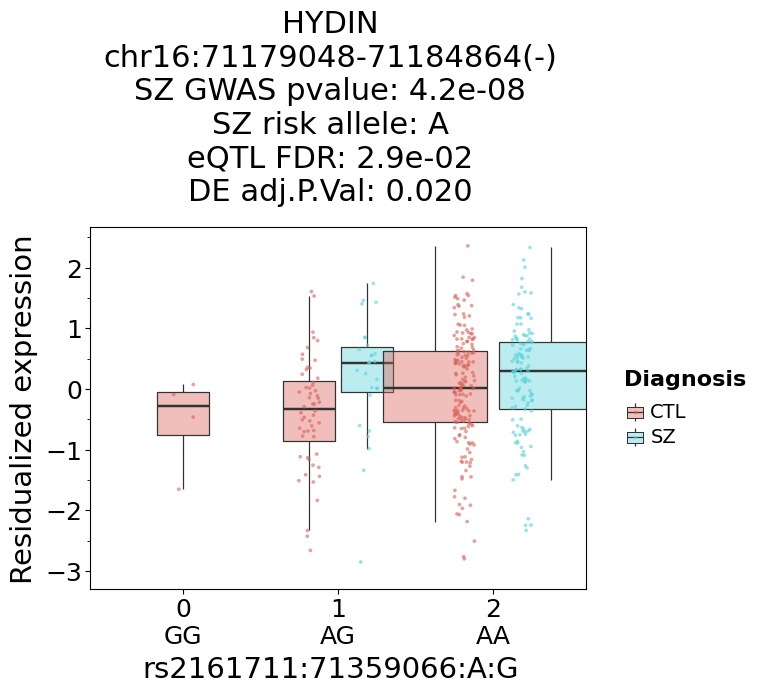

<ggplot: (8746637674981)>


In [30]:
for xx in range(df2.shape[0]):
    gg = gwas_annotated_eqtl_pheno_plot(df2.iloc[xx, :].SNP_eqtl, 
                                        df2.iloc[xx, :].gene, 'Dx')
    print(gg)
    label = '%s/eqtl_gwas_%s' % (feature, df2.iloc[xx, :].Symbol)
    save_plot(gg, label)